# Perceptron Algorithm from Scratch : Iris Dataset

#### Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib inline
import random
import seaborn as sns
import math

#### Import Data

In [2]:
df = pd.read_csv('/Users/prasunsurana/opt/anaconda3/pkgs/bokeh-2.2.3-py38_0/lib/python3.8/site-packages/bokeh/sampledata/_data/iris.csv')
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


#### Check for missing values

In [3]:
df.isnull().sum()

sepal_length    0
sepal_width     0
petal_length    0
petal_width     0
species         0
dtype: int64

#### Data Visualisation

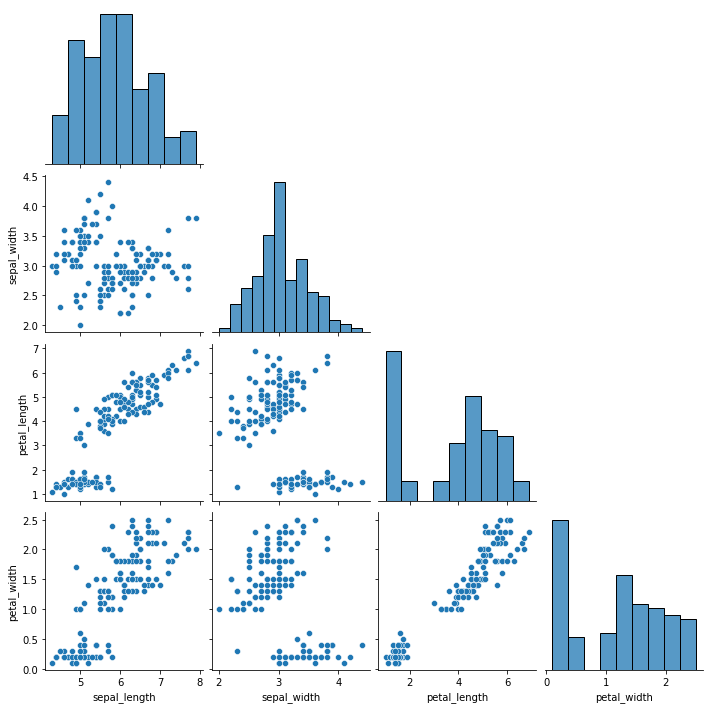

In [4]:
sns.pairplot(df, corner=True)

We are looking for data that is linearly separable. The plot for Petal Length vs. Sepal Length seems to be suitable. We can therefore discard irrelevant columns in our dataset.

In [5]:
df = df.drop(columns = ['petal_width', 'sepal_width'])
df

,sepal_length,petal_length,species
0,5.1,1.4,setosa
1,4.9,1.4,setosa
2,4.7,1.3,setosa
3,4.6,1.5,setosa
4,5.0,1.4,setosa
...,...,...,...
145,6.7,5.2,virginica
146,6.3,5.0,virginica
147,6.5,5.2,virginica
148,6.2,5.4,virginica


#### Data Scaling

Currently, there is no need to scale our data, since both petal length and sepal length are measured in the same units. Additionally, the scales of both features are already similar, so we leave both features unscaled, which will also help with predictions of new data points. If needed, the code is below.

In [6]:
# from sklearn.preprocessing import MinMaxScaler

# scaler = MinMaxScaler()
# df['petal_length'] = scaler.fit_transform(df[['petal_length']])
# df['sepal_length'] = scaler.fit_transform(df[['sepal_length']])
# df

#### Data Visualisation 

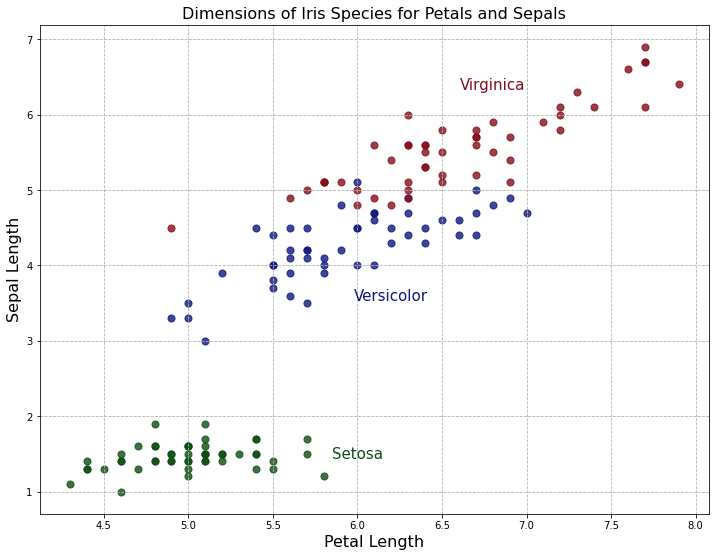

In [7]:
labels = {'Setosa': (6.0,1.5),
         'Versicolor': (6.2,3.6),
         'Virginica': (6.8,6.4)}

customPalette = ['#0e4d12', '#0f167d', '#820e1a']

plt.figure(figsize=(12,9))
plt.xlabel('Petal Length', size=16)
plt.ylabel('Sepal Length', size=16)
plt.title('Dimensions of Iris Species for Petals and Sepals', size=16)

for i, label in enumerate(labels.keys()):
    
    plt.scatter(x=df.loc[df['species']==label.lower(), 'sepal_length'], 
                y=df.loc[df['species']==label.lower(),'petal_length'], 
                color=customPalette[i], 
                alpha=0.8, s = 50)
        
    plt.annotate(label,
                 xy = labels[label],
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=15, weight='light',
                 color=customPalette[i]) 
    
plt.grid(linestyle='--')

plt.show()

We can see that the Virginica species tends to be the biggest. For simplicity, we will use Versicolor as the lower bound of Virginica, and therefore only run our Perceptron Algorithm to differentiate between Setosa and Versicolor. Therefore, anything above of what should be our optimal decision boundary can be classified as either one of Versicolor and Virginica, i.e. they have, in effect, been grouped together.

#### Label Encoding

We are labeling Setosa as 0 and Virginica + Versicolor as 1.

In [8]:
df['y'] = np.nan

for i in range(len(df)):
    if df.iloc[i, 2] == 'setosa':
        df.iloc[i, 3] = -1
    else:
        df.iloc[i, 3] = 1
       
df = df[['petal_length', 'sepal_length', 'species', 'y']]
df

,petal_length,sepal_length,species,y
0,1.4,5.1,setosa,-1.0
1,1.4,4.9,setosa,-1.0
2,1.3,4.7,setosa,-1.0
3,1.5,4.6,setosa,-1.0
4,1.4,5.0,setosa,-1.0
...,...,...,...,...
145,5.2,6.7,virginica,1.0
146,5.0,6.3,virginica,1.0
147,5.2,6.5,virginica,1.0
148,5.4,6.2,virginica,1.0


#### Creating Training and Testing Datasets

We will use a Stratified K-Fold Cross Validation method to split our dataset into the training and testing sets. This will ensure representative samples for training our algorithm.

In [9]:
from sklearn.model_selection import StratifiedKFold as SKF

skf = SKF(n_splits=4)

for train_index, test_index in skf.split(df, df['species']):
    train_set = df.loc[train_index]
    test_set = df.loc[test_index]
    
train_set.head()

,petal_length,sepal_length,species,y
0,1.4,5.1,setosa,-1.0
1,1.4,4.9,setosa,-1.0
2,1.3,4.7,setosa,-1.0
3,1.5,4.6,setosa,-1.0
4,1.4,5.0,setosa,-1.0


#### Maths of the Perceptron Algorithm

We initialize a weight vector w, and x is the vector of features in our model: $$ \vec{w} = \begin{pmatrix}
w_{1}\\
w_{2}
\end{pmatrix}, 
\vec{x} = \begin{pmatrix}
x_{1}\\
x_{2}
\end{pmatrix}
$$ 

We transform $ \vec{w} $ by adding b, and $ \vec{x} $ by adding 1 as a new dimension to each vector.
$$ \vec{w} = \begin{pmatrix}
w_{1}\\
w_{2}\\
b
\end{pmatrix}, 
\vec{x} = \begin{pmatrix}
x_{1}\\
x_{2}\\
1
\end{pmatrix}
$$ 

We have added b to $ \vec{w} $ and 1 to $ \vec{x} $ so that we can represent the bias term simply as a new dimension, rather than having to worry about the intercept of the hyperplane; it is automatically taken into account in the new transformed vectors. Now we can see that if we take the inner product of both vectors, we get a line that defines a hyperplane:
$$ w_{1}x_{1} + w_{2}x_{2} + b = 0 $$

Starting with $ \vec{w} $ as the zero vector, we can create an update rule. We know that 
$ sign(y) = \left\{
    \begin{array}\\
        1 & \mbox{if } \ Virginica \ or \ Versicolor \\
        0 & \mbox{if } \ Setosa \\
    \end{array}
\right. $

We expect positive samples to be on the right side of the hyperplane, which is defined as 0. Hence, when the sample Versicolor or Virginica, we expect the label to be 1 if $ \sum_{i=1}^n w_{i}x_{i} > 0 $ and 0 if $ \sum_{i=1}^n w_{i}x_{i} > 0 $. 

If we calculate $ \sum_{i=1}^n w_{i}x_{i} $ for a positive sample but it is less than zero, we know it has been misclassified. Hence, we can update our hyperplane $ w = w + x $. If we calculate $ \sum_{i=1}^n w_{i}x_{i} $ for a negative sample but it is greater than zero, we update our hyperplane $ w = w - x $.

The hyperplane will converge until it reaches to optimal separating hyperplane $ w^* $. The upper bound on the number of updates until optimality is $ \frac{1}{\gamma} $, where gamma is the distance between the optimal hyperplane $ w^* $ and the data point closest to it. 

#### The Perceptron Algorithm

In [13]:
class Perceptron:
    """Initializes Perceptron
    ---------------------------
    no_iter: Number of Iterations
    rate: Learning Rate of Perceptron Convergence"""
    
    def __init__(self, epochs, rate):
        self.epochs = epochs
        self.rate = rate
        
    def fit(self, data):
        
        np.random.seed(1003)
        w = np.random.rand(3,1)
        self.errors = []
        for i in range(self.epochs):
            errors = 0
            for j in range(len(train_set)):
                X = np.array(data.iloc[j,:2])
                X = np.append(X, 1).reshape(1,-1)
                if (data.iloc[j,3] * X@w)[0][0] < 0:
                    w = w + self.rate*(data.iloc[j,3] * X).T
                    errors += 1
            self.errors.append(errors)
            if errors == 0:
                break
        return w, self.errors
                    
    def plot_line(self, data, w):
        
        X = []
        Y = []
        m = -(w[2]/w[1])/(w[2]/w[0]) # slope of separating hyperplane
        b = -w[2]/w[1] # y-intercept of separating hyperplane
        for i in range(math.floor(min(data.iloc[:,0])), math.ceil(max(data.iloc[:,0])) + 1):
            X.append(i)
            Y.append((m*i) + b)
        
        return X, Y
    
    def plot_boundary(self, data):
        
        labels = {'Setosa': (6.0,1.5),
                 'Versicolor': (6.2,3.6)}

        customPalette = ['#0e4d12', '#0f167d']

        plt.figure(figsize=(12,9))
        plt.xlabel('Petal Length (cm)', size=16)
        plt.ylabel('Sepal Length (cm)', size=16)
        plt.title('Dimensions of Iris Species for Petals and Sepals', size=16)

        for i, label in enumerate(labels.keys()):
    
            plt.scatter(x=data.loc[data['species']==label.lower(), 'petal_length'], 
                y=data.loc[data['species']==label.lower(),'sepal_length'], 
                color=customPalette[i], 
                alpha=0.8, s = 50)
        
            plt.annotate(label,
                 xy = labels[label],
                 horizontalalignment='center',
                 verticalalignment='center',
                 size=15, weight='light',
                 color=customPalette[i]) 
    
        w, errors = self.fit(data)
        X, Y = self.plot_line(data, w)
        plt.plot(X, Y)
        
        plt.grid(linestyle='--')
        plt.xlim([0,6])
        plt.ylim([4,7.5])
        plt.show()
        return X, Y
    
    def animation(self, X, Y):
        fig, ax = plt.subplots(1,1)
        
        np.random.seed(1003)
        self.w = np.random.rand(3,1)
        
        ax.plot(X[0:37,0], X[0:37,1], c='#0e4d12', alpha=0.8, s = 50)
        ax.plot(X[50:86,0], X[50:86,1], c = '#0f167d', alpha=0.8, s = 50)
        
        self.line, = ax.plot([], [], lw=2) 
        anim = FuncAnimation(fig, self.animate, init_func=self.init_plot, fargs=(X, y,), frames=self.n_iter, interval=200, blit=True)
        
        

#### Training the Perceptron

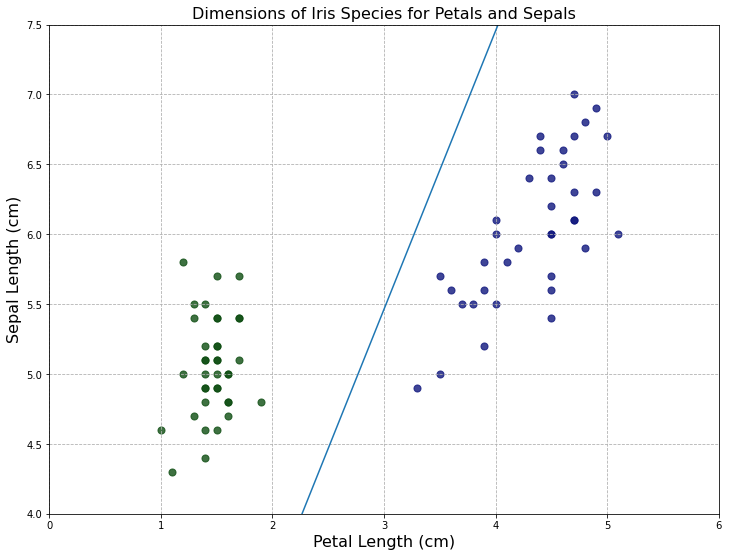

In [14]:
perceptron = Perceptron(15, 1)
X, Y = perceptron.plot_boundary(train_set)

#### Testing the Perceptron

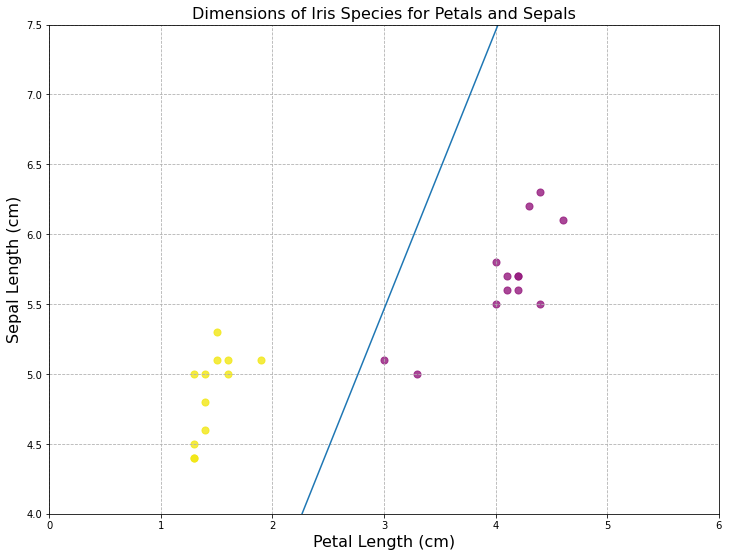

In [15]:
labels = {'Setosa': (6.0,1.5),
          'Versicolor': (6.2,3.6)}

customPalette = ['#f2e713', '#94197d']

plt.figure(figsize=(12,9))
plt.xlabel('Petal Length (cm)', size=16)
plt.ylabel('Sepal Length (cm)', size=16)
plt.title('Dimensions of Iris Species for Petals and Sepals', size=16)

for i, label in enumerate(labels.keys()):
    
    plt.scatter(x=test_set.loc[test_set['species']==label.lower(), 'petal_length'], 
        y=test_set.loc[test_set['species']==label.lower(),'sepal_length'], 
        color=customPalette[i], 
        alpha=0.8, s = 50)
        
    plt.annotate(label,
            xy = labels[label],
            horizontalalignment='center',
            verticalalignment='center',
            size=15, weight='light',
            color=customPalette[i]) 
            
plt.plot(X,Y)
        
plt.grid(linestyle='--')
plt.xlim([0,6])
plt.ylim([4,7.5])
plt.show()

The purple points above show Versicolor, and the yellow points are Setosa. As expected, all the Setosa testing points are on the left of the boundary and the Versicolor testing points on the right, i.e. our decision boundary correctly classifies all our testing data. However, the sample size is small, and to get a more complete picture of how accurate our decision boundary is, we may need more training and testing samples. 